# Importing libraries

In [1]:
import cv2
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Sklearn

In [3]:
from sklearn.model_selection import train_test_split

# Data path

In [4]:
DATA_PATH = '/kaggle/input/landcoverai'

# Wandb

In [5]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [6]:
wandb.init(project='MLOPS')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Tensorflow

In [7]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Activation, BatchNormalization, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Spliting images and annotations

In [8]:
#!/usr/bin/env python3

import glob
import os

import cv2

IMGS_DIR = "/kaggle/input/landcoverai/images"
MASKS_DIR = "/kaggle/input/landcoverai/masks"
OUTPUT_DIR = "./output"

TARGET_SIZE = 512
MAX_IMAGES = 3000  # Limit to 10,000 image-mask pairs

img_paths = glob.glob(os.path.join(IMGS_DIR, "*.tif"))
mask_paths = glob.glob(os.path.join(MASKS_DIR, "*.tif"))

img_paths.sort()
mask_paths.sort()

os.makedirs(OUTPUT_DIR, exist_ok=True)
total_images_created = 0

for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
    img_filename = os.path.splitext(os.path.basename(img_path))[0]
    mask_filename = os.path.splitext(os.path.basename(mask_path))[0]
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)

    assert img_filename == mask_filename and img.shape[:2] == mask.shape[:2]

    k = 0
    for y in range(0, img.shape[0], TARGET_SIZE):
        for x in range(0, img.shape[1], TARGET_SIZE):
            if total_images_created >= MAX_IMAGES:
                break  # Exit the loop once the limit is reached

            img_tile = img[y:y + TARGET_SIZE, x:x + TARGET_SIZE]
            mask_tile = mask[y:y + TARGET_SIZE, x:x + TARGET_SIZE]

            if img_tile.shape[0] == TARGET_SIZE and img_tile.shape[1] == TARGET_SIZE:
                out_img_path = os.path.join(OUTPUT_DIR, "{}_{}.jpg".format(img_filename, k))
                cv2.imwrite(out_img_path, img_tile)

                out_mask_path = os.path.join(OUTPUT_DIR, "{}_{}_m.png".format(mask_filename, k))
                cv2.imwrite(out_mask_path, mask_tile)

                total_images_created += 1
            k += 1

    print("Processed {} {}/{}".format(img_filename, i + 1, len(img_paths)))
    
    if total_images_created >= MAX_IMAGES:
        break  # Exit the outer loop once the limit is reached


Processed M-33-20-D-c-4-2 1/41
Processed M-33-20-D-d-3-3 2/41
Processed M-33-32-B-b-4-4 3/41
Processed M-33-48-A-c-4-4 4/41
Processed M-33-7-A-d-2-3 5/41
Processed M-33-7-A-d-3-2 6/41
Processed M-34-32-B-a-4-3 7/41
Processed M-34-32-B-b-1-3 8/41
Processed M-34-5-D-d-4-2 9/41
Processed M-34-51-C-b-2-1 10/41


In [9]:
def load_data(path):
    images = []
    annotations = []
    
    width = 512
    height = 512

    length = len(os.listdir(path))


    for i, img_name in enumerate(os.listdir(path)):
      
        if img_name.endswith('.jpg'):
          #print(img_name)
          img = cv2.imread(os.path.join(path,img_name))
          #print(img)
          img = cv2.resize(img, (width, height))
          images.append(img)

        if img_name.endswith('.png'):
          annot = cv2.imread(os.path.join(path, img_name))
          annot = cv2.resize(annot, (width, height))
          annotations.append(annot)
        

    return np.array(images), np.array(annotations)

In [10]:
image, annotation = load_data('/kaggle/working/output')

In [11]:
len(image), len(annotation)

(3000, 3000)

# Spliting 

In [12]:
images_train, images_test, masks_train, masks_test = train_test_split(image, annotation, test_size=0.2, random_state=42)

# Unet architecture

In [13]:
import tensorflow as tf
from tensorflow import keras

def laddernet_new(input_size=(512, 512, 3), dropout_rate=0.2):
    inputs = Input(input_size)

    conv1 = Conv2D(64, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(64, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(128, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(256, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(512, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)

    # Decoder
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(bn4), conv3], axis=3)
    up6 = Dropout(dropout_rate)(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(256, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(bn6), conv2], axis=3)
    up7 = Dropout(dropout_rate)(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(128, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(bn7), conv1], axis=3)
    up8 = Dropout(dropout_rate)(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(64, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    conv10 = Conv2D(3, (1, 1), activation="sigmoid")(bn8)

    return Model(inputs=inputs, outputs=conv10)

In [14]:
input_shape = image[0].shape
input_shape

(512, 512, 3)

In [15]:
model = laddernet_new(input_shape, dropout_rate=0.2)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 512, 512, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 64)         36928     ['activation[0][0]']          
                                                                                              

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model.fit(images_train, masks_train, validation_split=0.2, batch_size=4, epochs=20, callbacks=[
        WandbMetricsLogger(log_freq=5),
        WandbModelCheckpoint("models"),
    ])

Epoch 1/20


2023-12-09 18:30:56.714014: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


480/480 [==============================] - ETA: 0s - loss: 0.2164 - accuracy: 0.7063

wandb: Adding directory to artifact (./models)... Done. 0.4s


480/480 [==============================] - 562s 1s/step - loss: 0.2164 - accuracy: 0.7063 - val_loss: -0.0705 - val_accuracy: 0.0052
Epoch 2/20
480/480 [==============================] - ETA: 0s - loss: -0.1142 - accuracy: 0.4683

wandb: Adding directory to artifact (./models)... Done. 0.4s


480/480 [==============================] - 525s 1s/step - loss: -0.1142 - accuracy: 0.4683 - val_loss: -0.1805 - val_accuracy: 0.3075
Epoch 3/20
480/480 [==============================] - ETA: 0s - loss: -0.2777 - accuracy: 0.5114

wandb: Adding directory to artifact (./models)... Done. 0.4s


480/480 [==============================] - 523s 1s/step - loss: -0.2777 - accuracy: 0.5114 - val_loss: -0.2750 - val_accuracy: 0.3807
Epoch 4/20
480/480 [==============================] - ETA: 0s - loss: -0.4025 - accuracy: 0.4943

wandb: Adding directory to artifact (./models)... Done. 0.4s


480/480 [==============================] - 522s 1s/step - loss: -0.4025 - accuracy: 0.4943 - val_loss: -0.9423 - val_accuracy: 0.9944
Epoch 5/20
480/480 [==============================] - ETA: 0s - loss: -0.5443 - accuracy: 0.4483

wandb: Adding directory to artifact (./models)... Done. 0.4s


480/480 [==============================] - 521s 1s/step - loss: -0.5443 - accuracy: 0.4483 - val_loss: -0.7063 - val_accuracy: 0.5630
Epoch 6/20
480/480 [==============================] - ETA: 0s - loss: -0.8660 - accuracy: 0.4465

wandb: Adding directory to artifact (./models)... Done. 0.4s


480/480 [==============================] - 519s 1s/step - loss: -0.8660 - accuracy: 0.4465 - val_loss: -1.0205 - val_accuracy: 0.6224
Epoch 7/20
480/480 [==============================] - ETA: 0s - loss: -1.0397 - accuracy: 0.4476

wandb: Adding directory to artifact (./models)... Done. 0.4s


480/480 [==============================] - 521s 1s/step - loss: -1.0397 - accuracy: 0.4476 - val_loss: -1.2382 - val_accuracy: 0.4878
Epoch 8/20
480/480 [==============================] - ETA: 0s - loss: -1.2572 - accuracy: 0.4408

wandb: Adding directory to artifact (./models)... Done. 0.4s


480/480 [==============================] - 521s 1s/step - loss: -1.2572 - accuracy: 0.4408 - val_loss: -1.8534 - val_accuracy: 0.3873
Epoch 9/20
480/480 [==============================] - ETA: 0s - loss: -1.1670 - accuracy: 0.4570

wandb: Adding directory to artifact (./models)... Done. 0.4s


480/480 [==============================] - 521s 1s/step - loss: -1.1670 - accuracy: 0.4570 - val_loss: -9.3120 - val_accuracy: 0.0322
Epoch 10/20
480/480 [==============================] - ETA: 0s - loss: -1.1295 - accuracy: 0.5289

wandb: Adding directory to artifact (./models)... Done. 0.4s


480/480 [==============================] - 520s 1s/step - loss: -1.1295 - accuracy: 0.5289 - val_loss: -2.4091 - val_accuracy: 0.4195
Epoch 11/20
480/480 [==============================] - ETA: 0s - loss: -1.4086 - accuracy: 0.5199

wandb: Adding directory to artifact (./models)... Done. 0.4s


480/480 [==============================] - 520s 1s/step - loss: -1.4086 - accuracy: 0.5199 - val_loss: -2.1180 - val_accuracy: 0.6509
Epoch 12/20
480/480 [==============================] - ETA: 0s - loss: -1.2301 - accuracy: 0.5191

wandb: Adding directory to artifact (./models)... Done. 0.4s


480/480 [==============================] - 518s 1s/step - loss: -1.2301 - accuracy: 0.5191 - val_loss: -3.5599 - val_accuracy: 0.5074
Epoch 13/20
480/480 [==============================] - ETA: 0s - loss: -1.4111 - accuracy: 0.5289

wandb: Adding directory to artifact (./models)... Done. 0.4s


480/480 [==============================] - 519s 1s/step - loss: -1.4111 - accuracy: 0.5289 - val_loss: -2.9452 - val_accuracy: 0.6930
Epoch 14/20
480/480 [==============================] - ETA: 0s - loss: -1.6125 - accuracy: 0.5171

wandb: Adding directory to artifact (./models)... Done. 0.4s


480/480 [==============================] - 519s 1s/step - loss: -1.6125 - accuracy: 0.5171 - val_loss: -1.6673 - val_accuracy: 0.5281
Epoch 15/20
480/480 [==============================] - ETA: 0s - loss: -2.1169 - accuracy: 0.5103

wandb: Adding directory to artifact (./models)... Done. 0.4s


480/480 [==============================] - 518s 1s/step - loss: -2.1169 - accuracy: 0.5103 - val_loss: -3.8460 - val_accuracy: 0.3870
Epoch 16/20
480/480 [==============================] - ETA: 0s - loss: -2.3203 - accuracy: 0.5296

wandb: Adding directory to artifact (./models)... Done. 0.4s


480/480 [==============================] - 518s 1s/step - loss: -2.3203 - accuracy: 0.5296 - val_loss: -4.9244 - val_accuracy: 0.6143
Epoch 17/20
480/480 [==============================] - ETA: 0s - loss: -2.5711 - accuracy: 0.5375

wandb: Adding directory to artifact (./models)... Done. 0.4s


480/480 [==============================] - 517s 1s/step - loss: -2.5711 - accuracy: 0.5375 - val_loss: -2.3885 - val_accuracy: 0.3151
Epoch 18/20
480/480 [==============================] - ETA: 0s - loss: -3.2113 - accuracy: 0.5212

wandb: Adding directory to artifact (./models)... Done. 0.4s


480/480 [==============================] - 519s 1s/step - loss: -3.2113 - accuracy: 0.5212 - val_loss: -7.7562 - val_accuracy: 0.9126
Epoch 19/20
480/480 [==============================] - ETA: 0s - loss: -4.2862 - accuracy: 0.5359

wandb: Adding directory to artifact (./models)... Done. 0.4s


480/480 [==============================] - 516s 1s/step - loss: -4.2862 - accuracy: 0.5359 - val_loss: -0.8563 - val_accuracy: 0.4749
Epoch 20/20
480/480 [==============================] - ETA: 0s - loss: -5.7060 - accuracy: 0.5684

wandb: Adding directory to artifact (./models)... Done. 0.4s


480/480 [==============================] - 516s 1s/step - loss: -5.7060 - accuracy: 0.5684 - val_loss: -2.4014 - val_accuracy: 0.6351


In [18]:
model.save('kaleidoEO.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


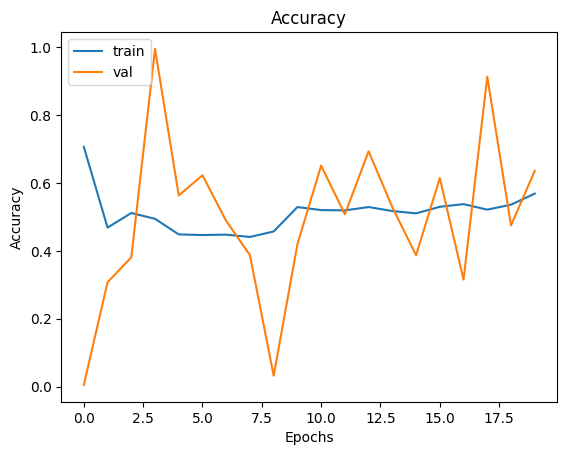

In [19]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','val'])
plt.show()

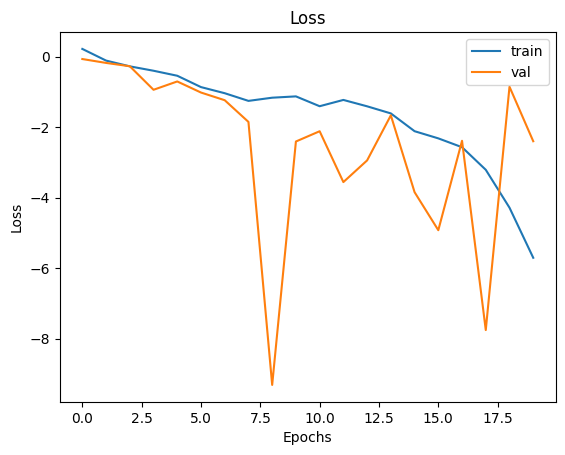

In [20]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val'])
plt.show()

In [21]:
def inferencing_model(input_image):
    input_image = cv2.imread(input_image)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = cv2.resize(input_image, (512, 512))  

    predictions = model.predict(np.expand_dims(input_image, axis=0))
    
    predicted_classes = np.argmax(predictions[0], axis=-1)  
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Display the original image
    ax[0].imshow(input_image)
    ax[0].set_title('Input Image')
    ax[0].axis('off')

    # Display the class labels
    ax[1].imshow(predicted_classes)  
    ax[1].set_title('Predicted Class Labels')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()


1/1 [==============================] - 3s 3s/step


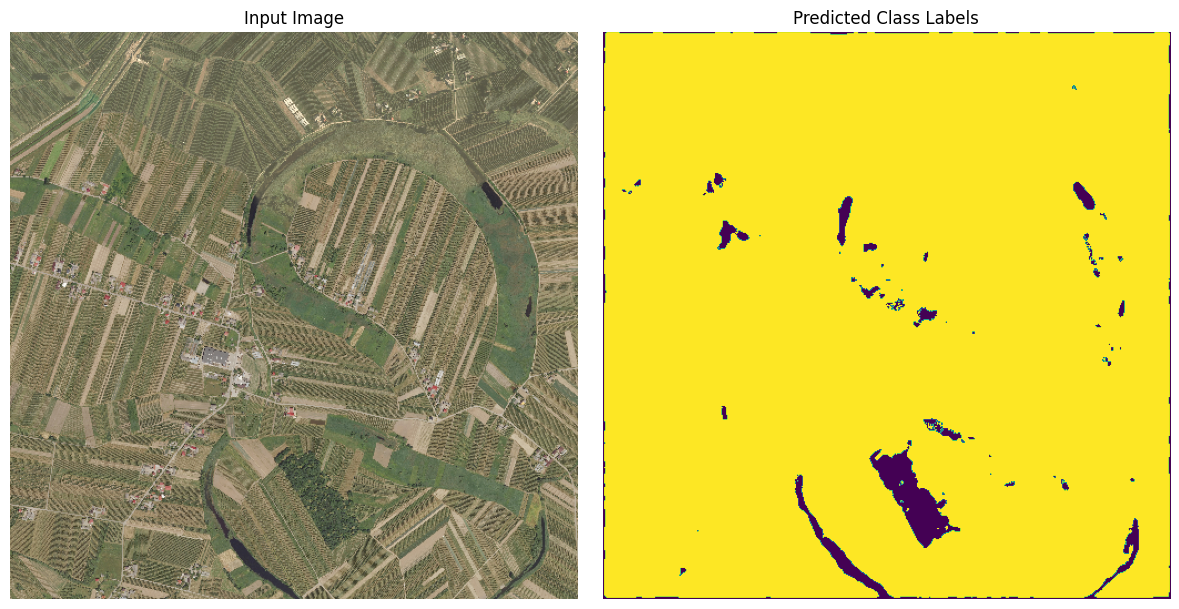

In [22]:
inferencing_model('/kaggle/input/landcoverai/images/M-34-56-A-b-1-4.tif')

In [26]:
def test_image(input_image):
    predictions = model.predict(np.expand_dims(input_image, axis=0))

    predicted_classes = np.argmax(predictions[0], axis=-1)  
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Display the original image
    ax[0].imshow(input_image)
    ax[0].set_title('Input Image')
    ax[0].axis('off')

    # Display the class labels
    ax[1].imshow(predicted_classes)  
    ax[1].set_title('Predicted Class Labels')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 25ms/step


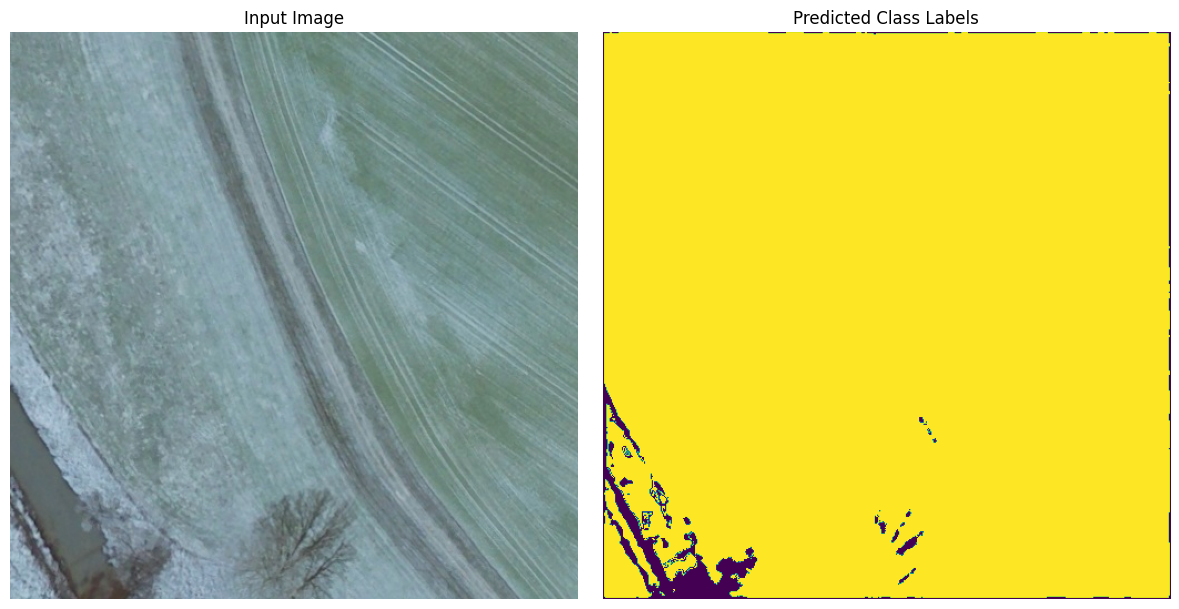

In [38]:
test_image(image[250])